In [3]:
import pandas as pd
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from itertools import product
import warnings
from pylab import rcParams
import numpy as np

In [5]:
df = pd.read_pickle('btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 0 to 1189
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   open_time          1190 non-null   datetime64[ns]
 1   BTCUSDT_open       1190 non-null   float64       
 2   BTCUSDT_high       1190 non-null   float64       
 3   BTCUSDT_low        1190 non-null   float64       
 4   BTCUSDT_close      1190 non-null   float64       
 5   BTCUSDT_volume     1190 non-null   float64       
 6   close_time         1190 non-null   datetime64[ns]
 7   qav                1190 non-null   float64       
 8   num_trades         1190 non-null   int64         
 9   taker_base_vol     1190 non-null   float64       
 10  taker_quote_vol    1190 non-null   float64       
 11  is_best_match      1190 non-null   int64         
 12  date               1190 non-null   datetime64[ns]
 13  usd_close          172 non-null    float64       
 14  spy_clos

### Visual EDA

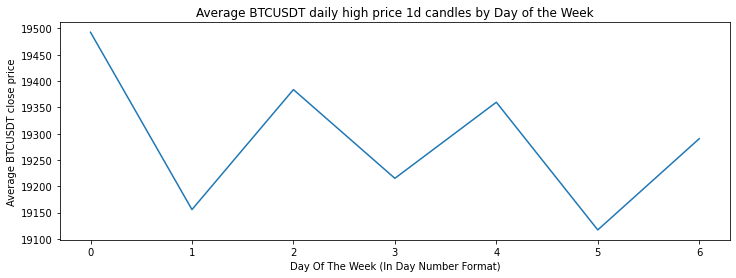

In [6]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby([df["close_time"].dt.dayofweek])["BTCUSDT_high"].mean().plot(kind='line', ax=axs)
plt.title('Average BTCUSDT daily high price 1d candles by Day of the Week')
plt.xlabel("Day Of The Week (In Day Number Format)");  # custom x label using matplotlib
plt.ylabel("Average BTCUSDT close price")
#plt.ylim(ymin=18400, ymax=18800)
plt.draw()

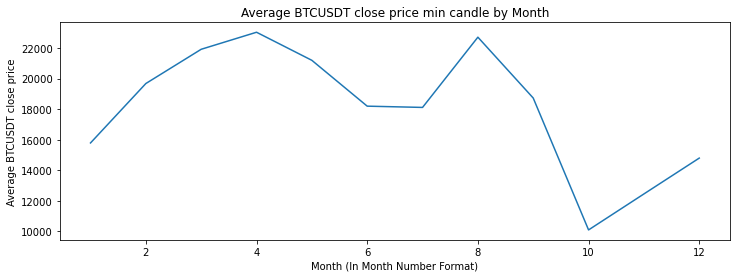

In [95]:
fig, axs = plt.subplots(figsize=(12, 4))

df.groupby([df["close_time"].dt.month])["BTCUSDT_close"].mean().plot(kind='line', ax=axs)
plt.title('Average BTCUSDT close price min candle by Month')
plt.xlabel("Month (In Month Number Format)");  # custom x label using matplotlib
plt.ylabel("Average BTCUSDT close price")
#plt.ylim(ymin=18200, ymax=18800)
plt.draw()

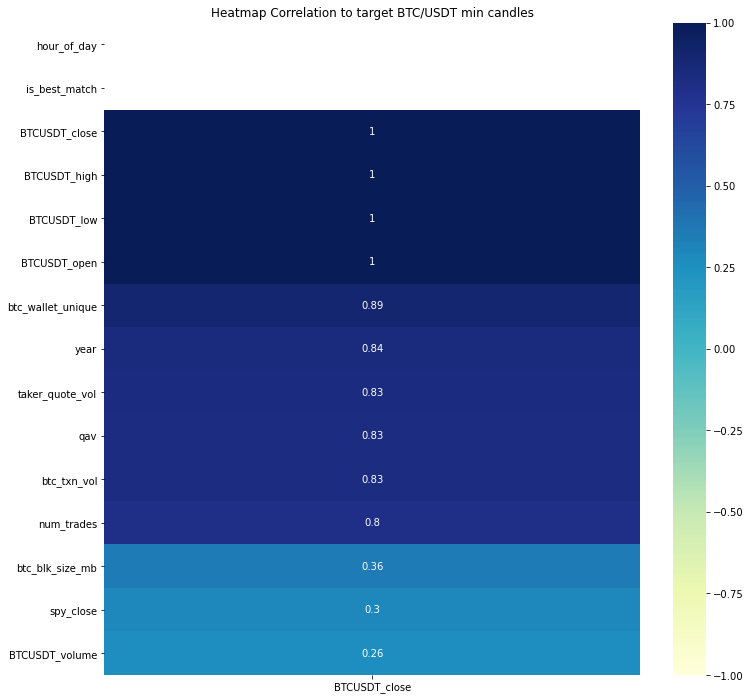

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr()[['BTCUSDT_close']].sort_values('BTCUSDT_close').tail(15),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.set_title('Heatmap Correlation to target BTC/USDT min candles')
ax.invert_yaxis()

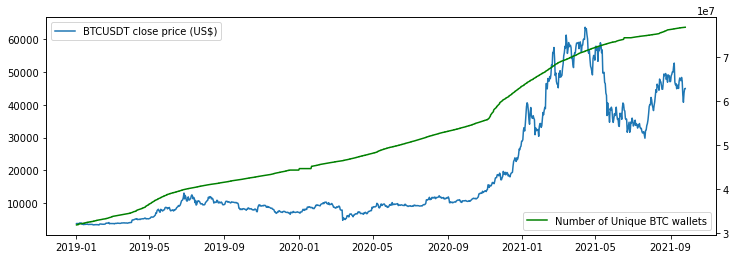

In [9]:
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
ax1.plot(df['close_time'], df['BTCUSDT_close'], label='BTCUSDT close price (US$)')
ax2=ax1.twinx()
ax2.plot(df['close_time'],df['btc_wallet_unique'],'g-', label='Number of Unique BTC wallets')
ax1.legend()
ax2.legend(loc=4)

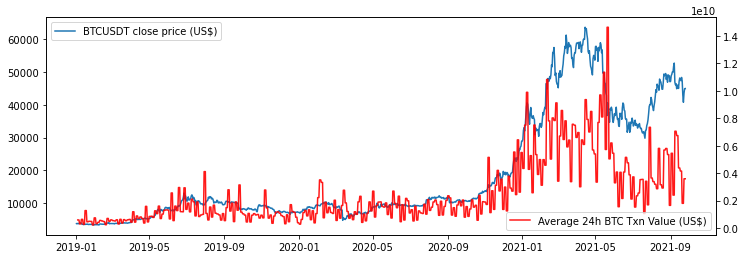

In [10]:
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
ax1.plot(df['close_time'], df['BTCUSDT_close'], label='BTCUSDT close price (US$)')
ax2=ax1.twinx()
ax2.plot(df['close_time'],df['btc_txn_vol'],'r-', label='Average 24h BTC Txn Value (US$)', alpha=0.9)
ax1.legend()
ax2.legend(loc=4)

### Computing the difference in daily returns and plotting it

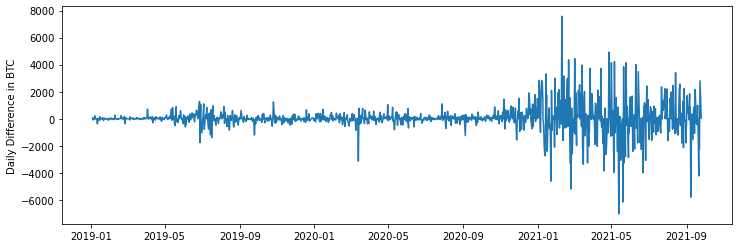

In [10]:
# Need to difference
fig, ax= plt.subplots(figsize=(12, 4))
ax1=plt.subplot(111)
df['close_diff'] = df.BTCUSDT_close.diff(periods=1) #we are using minute candles here,
df.rolling_daily_return.dropna(inplace=True)
ax.plot(df['close_time'],df['close_diff'])
ax.set_ylabel("Daily Difference in BTC")
plt.show()

## Applying an ADF test to the differenced data 

In [11]:
df.dropna(how='any',inplace=True)
df['close_diff'].isnull().values.any()

False

In [12]:
result = adfuller(df['close_diff'])
pvalue = result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

stationary


Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary. We should therefore be able to predict daily returns with MA/ARIMA quite easily with a univariate model

https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06

### Plotting the Autocorrelation Function and the Partial Autocorrelation Function

The Autocorrelation function plot will let you know how the given time series is correlated with itself

If there is a Positive autocorrelation at lag 1 then we use the AR model

If there is a Negative autocorrelation at lag 1 then we use the MA model


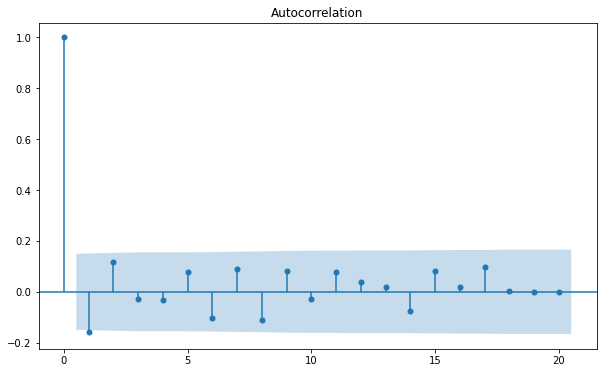

In [13]:
plot_acf(df['close_diff'], lags=20)
plt.show()

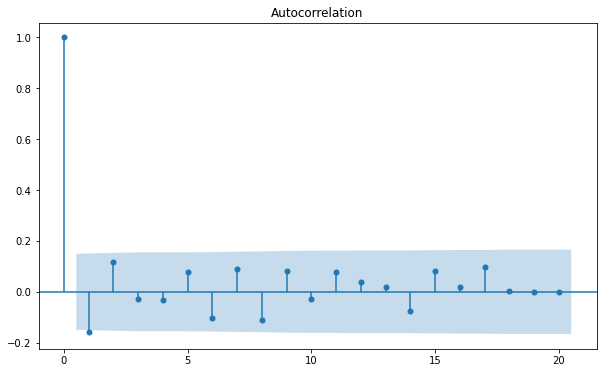

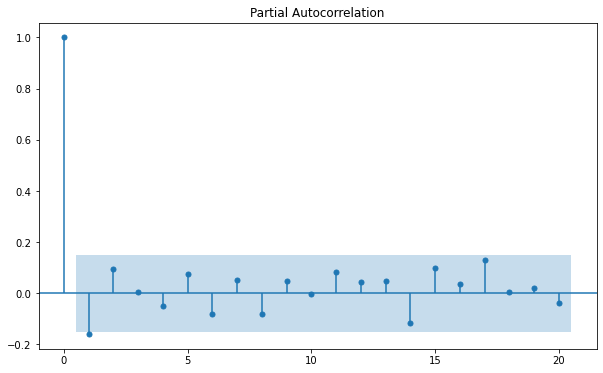

In [14]:
plot_acf(df['close_diff'], lags=20)
plot_pacf(df['close_diff'], lags=20)
plt.show()

### Seasonal Decompose

/var/folders/j5/x7jwjkqx43nb9p2pjd5tnwvm0000gn/T/ipykernel_15303/1869224287.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df['BTCUSDT_close'], model='additive', freq=28)


<Figure size 432x288 with 0 Axes>

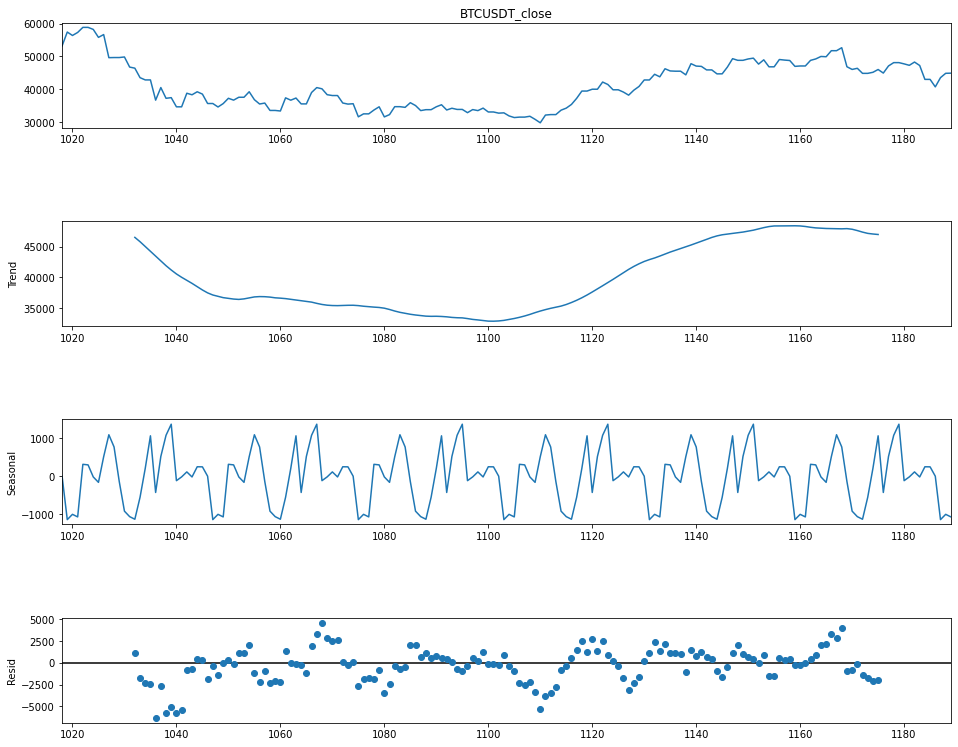

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
#frequency of 28 as we want to explor the relatiionship for monthly btc option expiries
result = seasonal_decompose(df['BTCUSDT_close'], model='additive', freq=28) 

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

### Train Test Split

No handles with labels found to put in legend.


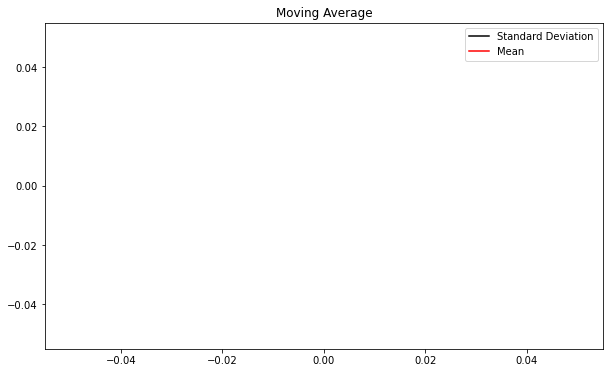

In [16]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.BTCUSDT_close)
moving_avg = df_log.rolling(60*12).mean()
std_dev = df_log.rolling(60*12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

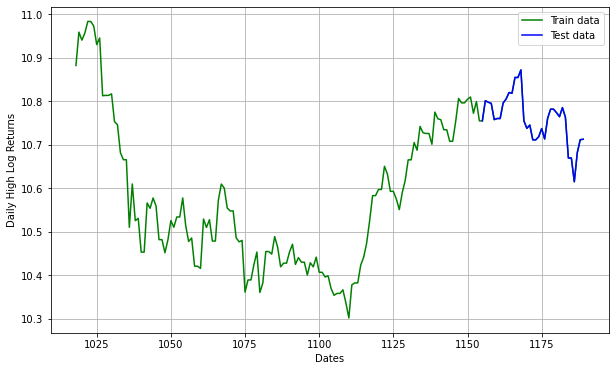

In [19]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily High Log Returns')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [27]:
df_log

1018    10.881814
1019    10.958428
1020    10.940112
1021    10.956313
1022    10.982952
          ...    
1185    10.669319
1186    10.614828
1187    10.681518
1188    10.711419
1189    10.712428
Name: BTCUSDT_close, Length: 172, dtype: float64

### ARIMA 

In [20]:
### walkforward validation on ARIMA for optimal pqd
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-460.567, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-461.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-461.330, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-462.396, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-460.313, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 232.198
Date:                Tue, 28 Sep 2021   AIC                           -462.396
Time:                        14:20:39   BIC                           -459.505
Sample:                             0   HQIC                          -461.221
                                - 134                                       

The Auto ARIMA model provided the optimal value of pdq as follows:
- P: 3
- D: 1
- Q: 3

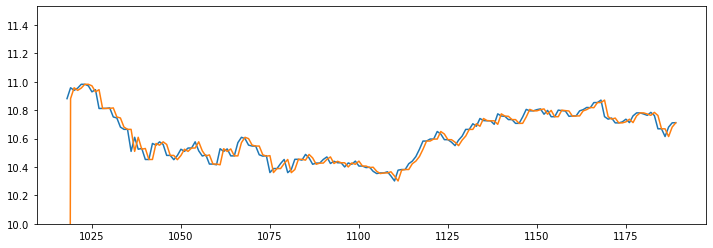

r2 score is:  -23.43812029894116
MSE is:  0.6901229631075337
RMSE is:  0.8307363980875846
MAE is:  0.09107001103505068
MAPE is:  0.008438072364424076


In [29]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

fig, ax= plt.subplots(figsize=(12, 4))
# Forecast the first MA(1) model
mod = ARIMA(df_log, order=(0,1,0)) #used pqd from arima walkforward validation
res = mod.fit()

orig_data = df_log.dropna()
pred = res.predict()

plt.plot(orig_data, label='Original Data')
plt.plot(pred, label='Predictions')
plt.ylim(10)
plt.show()

print('r2 score is: ',r2_score(orig_data, pred))
print('MSE is: ',mean_squared_error(orig_data, pred))
print('RMSE is: ',np.sqrt(mean_squared_error(orig_data, pred)))
print('MAE is: ',mean_absolute_error(orig_data, pred))
print('MAPE is: ',mean_absolute_percentage_error(orig_data, pred))

r2 of 73% is not really ideal in this case. We should try to see if using ARIMA to predict daily highs/lows could be a viable model for real world scenarios

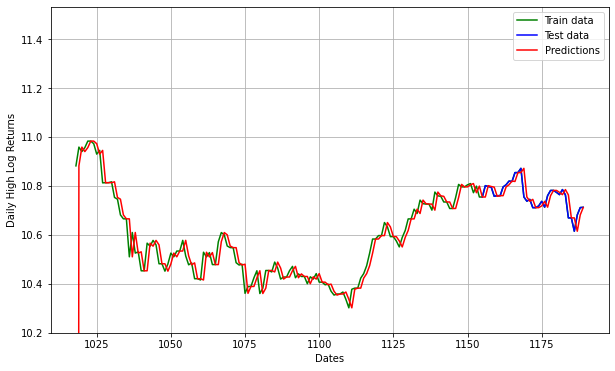

In [32]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily High Log Returns')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.plot(pred, 'red', label='Predictions')
plt.ylim(10.2)
plt.legend()